## Detecting Gravitational-Waves from Binary Black Hole Merger with LIGO Open Data


In [2]:
import numpy as np
import math
from gwpy.timeseries import TimeSeries
from scipy.linalg import fractional_matrix_power
from scipy.stats import zscore

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

import wget
import os 

import lmfit
from lmfit import Model, minimize, fit_report, Parameters

### Downloading the data

In [ ]:
try: 
    os.mkdir('GW') 
except OSError as error: 
    print(error)

wget.download('https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5', 'GW')

### Set Parameters
`fn` --> Contains data from the LIGO detector (indicated by H1, which stands for Hanford), with specific parameters like sampling rate (4KHZ), and it follows a format used by the Gravitational Wave Open Science Center (GWOSC)

`tevent` -->  GPS time of an event (A continuous time scale that started on January 6, 1980, and is often used in scientific data to provide a precise time reference.)
* The value `1126259462.422` represents the time at which a specific gravitational wave event (GW150914) was detected.

`evtname` --> Event name `GW150914`

`detector` -->
* `H1` - The LIGO Hanford detector
* `L1` - The LIGO Livingston detector


In [3]:
fn = 'GW/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5' 
tevent = 1126259462.422
evtname = 'GW150914'
detector = 'H1'

* Loading Data: The `TimeSeries.read()` method reads the LIGO data from the file specified by fn in the hdf5.gwosc format.
* Defining Center: center is set to the GPS time of the event, tevent, converted to an integer.
* Cropping Data: The `.crop()` method extracts a 32-second window (16 seconds before and 16 seconds after the event) from the time-series data, focusing on the event of interest.

<Figure size 640x480 with 0 Axes>

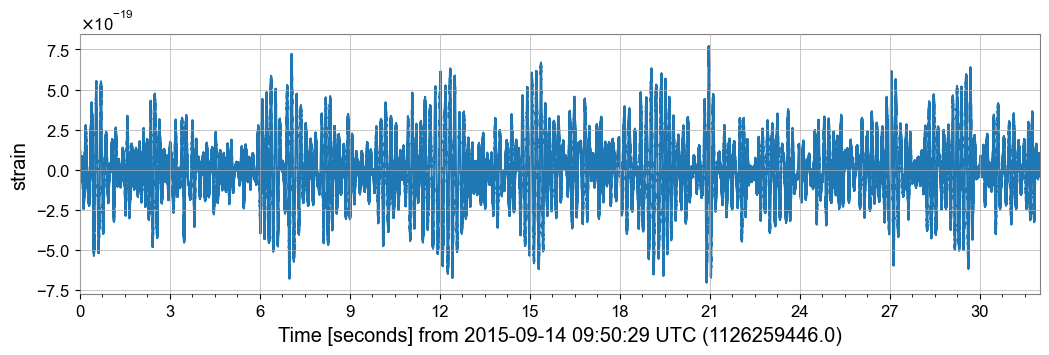

In [4]:
strain = TimeSeries.read(fn, format='hdf5.gwosc')
center = int(tevent)
strain = strain.crop(center-16, center+16)

# Show the LIGO strain vs. time
plt.figure()
strain.plot()
plt.ylabel('strain')
plt.show()

### Plotting in the Frequency Domain

Plot the ASD vs. frequency.

Plotting these data in the Fourier domain gives us an idea of the frequency content of the data. A way to visualize the frequency content of the data is to plot the amplitude spectral density, ASD. The ASDs are the square root of the power spectral densities (PSDs), which are **averages of the square of the fast fourier transforms (FFTs)** of the data. They are an estimate of the "strain-equivalent noise" of the detectors versus frequency, which limit the ability of the detectors to identify GW signals.

* `strain.asd()` computes the Amplitude Spectral Density (ASD) of the time-series data. The ASD represents how the amplitude of the signal varies with frequency.
* `fftlength=8` specifies the length of the Fast Fourier Transform (FFT) segments in seconds. In this case, each segment of the time series is 8 seconds long.

<Figure size 640x480 with 0 Axes>

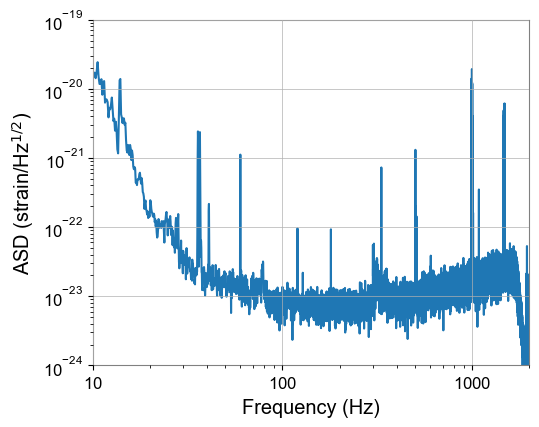

In [5]:
# ASD be created by the built in ASD function in GWpy
asd = strain.asd(fftlength=8)

plt.clf() #clears the current figure in Matplotlib, which ensures that the plot is reset before creating a new one.
asd.plot()
plt.xlim(10, 2000)
plt.ylim(1e-24, 1e-19)
plt.ylabel('ASD (strain/Hz$^{1/2})$')
plt.xlabel('Frequency (Hz)')
plt.show()

You can see strong spectral lines in the data - corresponding to large power sources at the corresponding frequencies. They are all of instrumental origin. Some are engineered into the detectors (mirror suspension resonances at ~500 Hz and harmonics, calibration lines, control dither lines, etc) and some (60 Hz and harmonics) are unwanted.

You can't see the signal in this plot, since it is relatively weak and less than a second long, while this plot averages over 32 seconds of data. So this plot is entirely dominated by instrumental noise.


## Apply filters in order to clean up the data

<h3>Whitening</h3>

From the ASD above, we can see that noise fluctuations are much larger at low and high frequencies and near spectral lines. 

We can "whiten" the data, suppressing the extra noise at low frequencies and at the spectral lines, to better see the weak signals in the most sensitive band. This is done by normalizing the power at all frequencies so that excess power at any frequency is more obvious.

<Figure size 640x480 with 0 Axes>

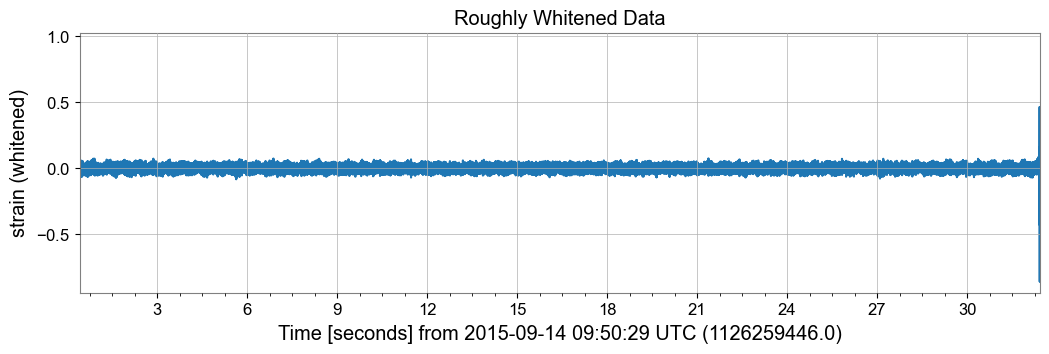

In [6]:
def rough_whitener(strain_data, crop_window=30): 
  asd_data = strain_data.asd()
  fft_data = strain_data.fft()
  whitened = np.fft.irfft(np.abs(1/asd_data)*fft_data)
  return whitened

whitened_timeseries = TimeSeries(rough_whitener(strain))
whitened_timeseries.t0 = tevent - 16 # defining start time for plot
whitened_timeseries.dt = 1/4096 # defining timestep at 4096 Hz
plt.clf()
whitened_timeseries[0:-1].plot() # you can plot different steps of time here
plt.ylabel('strain (whitened)')
plt.title('Roughly Whitened Data')
plt.show()

### Removing Artifacts

The GWpy whitener does some additional fancy time-series operations, including fixing the edge effects of the rough whitener using a window function, so we will use that included function. 

<Figure size 640x480 with 0 Axes>

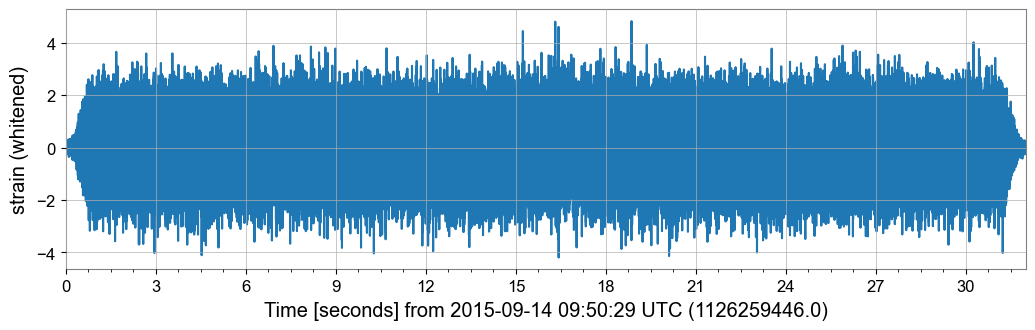

In [7]:
# Whitening data using GWpy 

white_data = strain.whiten() #We will just use the GWpy whitening function here
plt.clf()
white_data.plot()
plt.ylabel('strain (whitened)')
plt.show()

<h3>Q-Transform</h3>

To see where in the frequency spectrum of our signal lies (and see what range to bandpass on), we take a q-transform of the data and check the time variation of frequency. This q-transform is formed by taking the magnitude of the Short-time Fourier transform, normally on a log-intensity axis (e.g. Energy).

<Figure size 640x480 with 0 Axes>

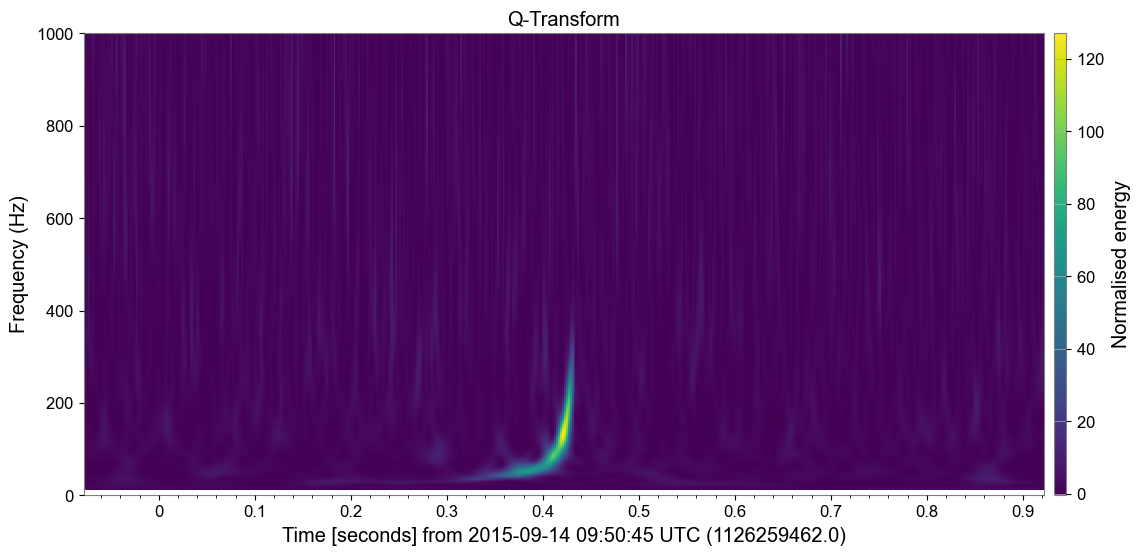

In [8]:
dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(tevent-dt, tevent+dt))

plt.clf()
fig = hq.plot()
ax = fig.gca()
fig.colorbar(label="Normalised energy")
ax.grid(False)
plt.xlim(tevent-0.5, tevent+0.5)
plt.ylim(0, 1000)
plt.ylabel('Frequency (Hz)')
plt.title('Q-Transform')
plt.show()

<h3>Bandpassing</h3>

A bandpass filter can select data from a specific range of frequencies and is used in a wide variety of physics applications. The code below shows you a framework to do bandpassing within GWpy. This will **select data with frequencies above bandpass_low and below bandpass_high**.

Below is defined a function that will plot the timeseries and ASD after applying a bandpass filter range. At first, a bandpass of `[1,1000]` is chosen, which essentially leaves the data unchanged. The plots are as follows:
- the whitened time series data after applying the bandpass
- a 0.3 second window of the whitened time series data, centered around the known event
- the ASD of the unwhitened data, after applying the bandpass

<Figure size 640x480 with 0 Axes>

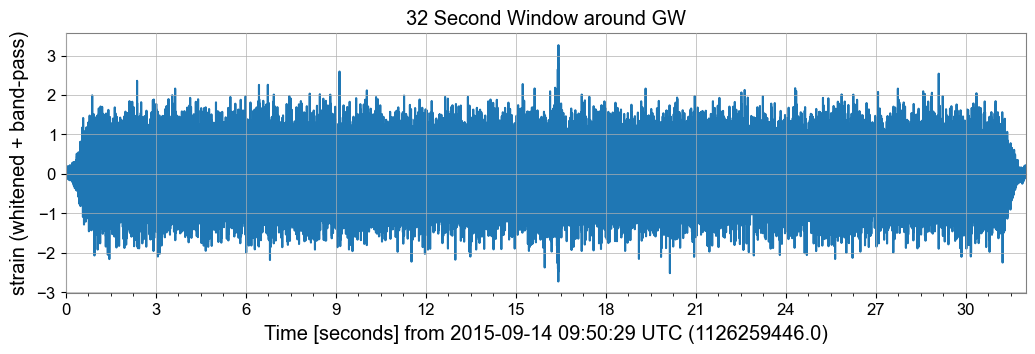

<Figure size 640x480 with 0 Axes>

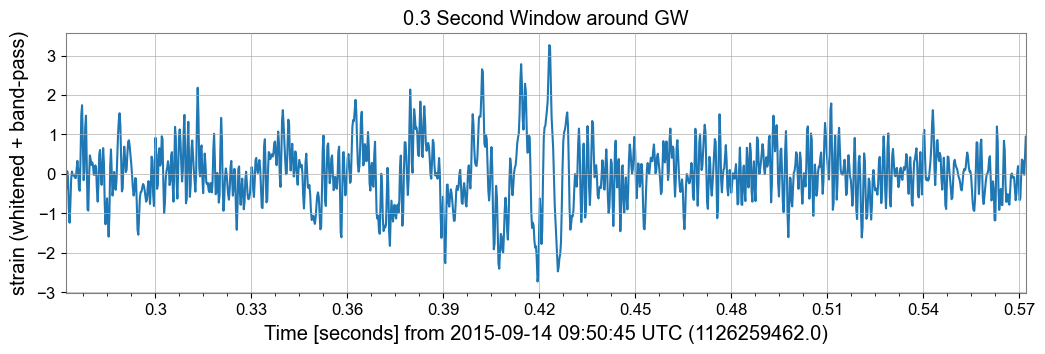

<Figure size 640x480 with 0 Axes>

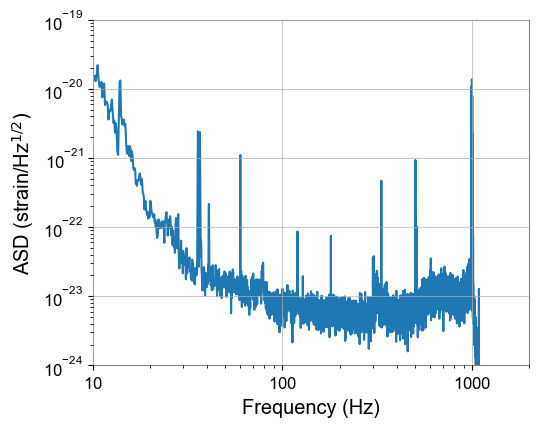

<TimeSeries([ 0.01026349, -0.04384023, -0.01024432, ...,
              0.10743095,  0.06862419,  0.08629983]
            unit=Unit(dimensionless),
            t0=<Quantity 1.12625945e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>

In [9]:
def bandpass(bandpass_low, bandpass_high): 
  white_data_bp = white_data.bandpass(bandpass_low, bandpass_high)

  plt.clf()
  white_data_bp.plot()
  plt.ylabel('strain (whitened + band-pass)')
  plt.title('32 Second Window around GW')
  plt.show()

  plt.clf()
  white_data_bp.plot()
  plt.ylabel('strain (whitened + band-pass)')
  plt.xlim(tevent-0.15, tevent+0.15)
  plt.title('0.3 Second Window around GW')
  plt.show()

  #Note: for the sake of comparison, we are using unwhitened strain
  strain_bandpass = strain.bandpass(bandpass_low, bandpass_high) 
  asd = strain_bandpass.asd(fftlength=8)
  plt.clf()
  asd.plot()
  plt.xlim(10, 2000)
  plt.ylim(1e-24, 1e-19)
  plt.ylabel('ASD (strain/Hz$^{1/2})$')
  plt.xlabel('Frequency (Hz)')
  plt.show()
  
  return white_data_bp


bandpass_low, bandpass_high = [1,1000]
bandpass(bandpass_low, bandpass_high)